In [5]:
import tensorflow as tf
import numpy
import os
import json, pickle
import pandas
from functools import partial, reduce
import importlib

import sys
sys.path.append('../libs')

import flacdb
import prepare_data
import initialize
import data_pipeline
import loss_metrics
import conv_model
import plot_batch

In [2]:
H = initialize.load_hypes()

In [3]:
sig_data_old, metadata_old = initialize.load_initial_data(must_have_bp=True)
diagnosis_init_old = initialize.load_diagnosis(H['icd_codes'])
diagnosis_augmented_old = initialize.augment_diagnosis(diagnosis_init_old, metadata_old)
diagnosis_old = initialize.fix_diagnosis(diagnosis_augmented_old)
priors_old = (diagnosis_old == 1).sum() / (diagnosis_old != 0).sum()
counts_old = (diagnosis_old == 1).any(level=0, axis=0).sum()

In [4]:
sig_data, metadata = initialize.load_initial_data(must_have_bp=False)
diagnosis_init = initialize.load_diagnosis(H['icd_codes'])
diagnosis_augmented = initialize.augment_diagnosis(diagnosis_init, metadata)
diagnosis = initialize.fix_diagnosis(diagnosis_augmented)
priors = (diagnosis == 1).sum() / (diagnosis != 0).sum()
counts = (diagnosis == 1).any(level=0, axis=0).sum()

In [6]:
%matplotlib widget
from matplotlib import pyplot

In [7]:
I = counts.argsort()
I = numpy.array([
    i for i in I 
    if not any(j in counts.index[i] for j in ['gender', 'race', 'least'])
])

In [8]:
names = loss_metrics.CODE_NAMES
names = {
    i: names[i] if i != 'died' else 'death' 
    for i in counts.index[I][::-1]
}
names = pandas.Series(names)
pandas.concat({
    'name': names,
    'old count': counts_old[I[::-1]],
    'new count': counts[I[::-1]],
    'old prior': priors_old[I[::-1]],
    'new prior': priors[I[::-1]]
}, axis=1)

,name,old count,new count,old prior,new prior
code,,,,,
4019,hypertensive,2115,4091,0.457041,0.466731
41401,coronary_atherosclerosis,1420,2630,0.304146,0.301452
42731,atrial_fibrillation,1424,2617,0.306482,0.303761
4280,congestive_heart_failure,1282,2518,0.279402,0.301330
2724,hyperlipidemia,1150,2398,0.249735,0.277544
5849,acute_kidney_failure,839,1800,0.181857,0.210272
25000,diabetes,904,1724,0.194947,0.201830
51881,acute_resp_failure,1020,1537,0.219207,0.174928
2859,anemia,579,1200,0.123650,0.135263


In [72]:
names = loss_metrics.CODE_NAMES
names = {
    i: names[i] if i != 'died' else 'death' 
    for i in counts.index[I][::-1]
}
names = pandas.Series(names)
pandas.concat({
    'name': names,
    'old count': counts_old[I[::-1]],
    'new count': counts[I[::-1]],
    'old prior': priors_old[I[::-1]],
    'new prior': priors[I[::-1]]
}, axis=1)

,name,old count,new count,old prior,new prior
code,,,,,
4019,hypertensive,2106,4090,0.456686,0.465626
41401,coronary_atherosclerosis,1414,2629,0.303647,0.300719
42731,atrial_fibrillation,1419,2616,0.306397,0.302998
4280,congestive_heart_failure,1278,2517,0.279266,0.300514
2724,hyperlipidemia,1148,2397,0.249947,0.276717
5849,acute_kidney_failure,838,1800,0.182185,0.209651
25000,diabetes,900,1724,0.194638,0.201369
51881,acute_resp_failure,1015,1536,0.218750,0.174434
2859,anemia,576,1199,0.123328,0.134753


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

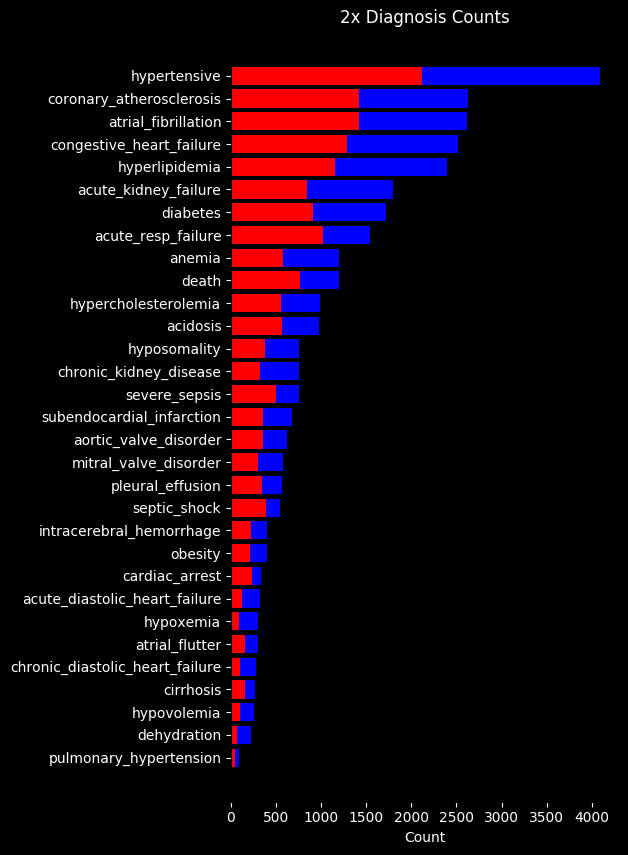

In [9]:
fig = pyplot.figure(1, facecolor='black', figsize=(5, 10))
fig.clear()
axis = fig.gca()
axis.set_facecolor('black')
axis.tick_params(axis='x', colors='white')
axis.tick_params(axis='y', colors='white')
axis.set_xlabel('Count', color='white')
# for spine in axis.spines.values():
#     spine.set_color('white')
pyplot.barh(range(len(I)), counts[I], color='blue', height=0.8, tick_label=names[::-1])
pyplot.barh(range(len(I)), counts_old[I], color='red', height=0.8, tick_label=names[::-1])
axis.set_title('2x Diagnosis Counts', color='white')
# fig.canvas.layout.height = '1000px'
# fig.canvas
display(fig)

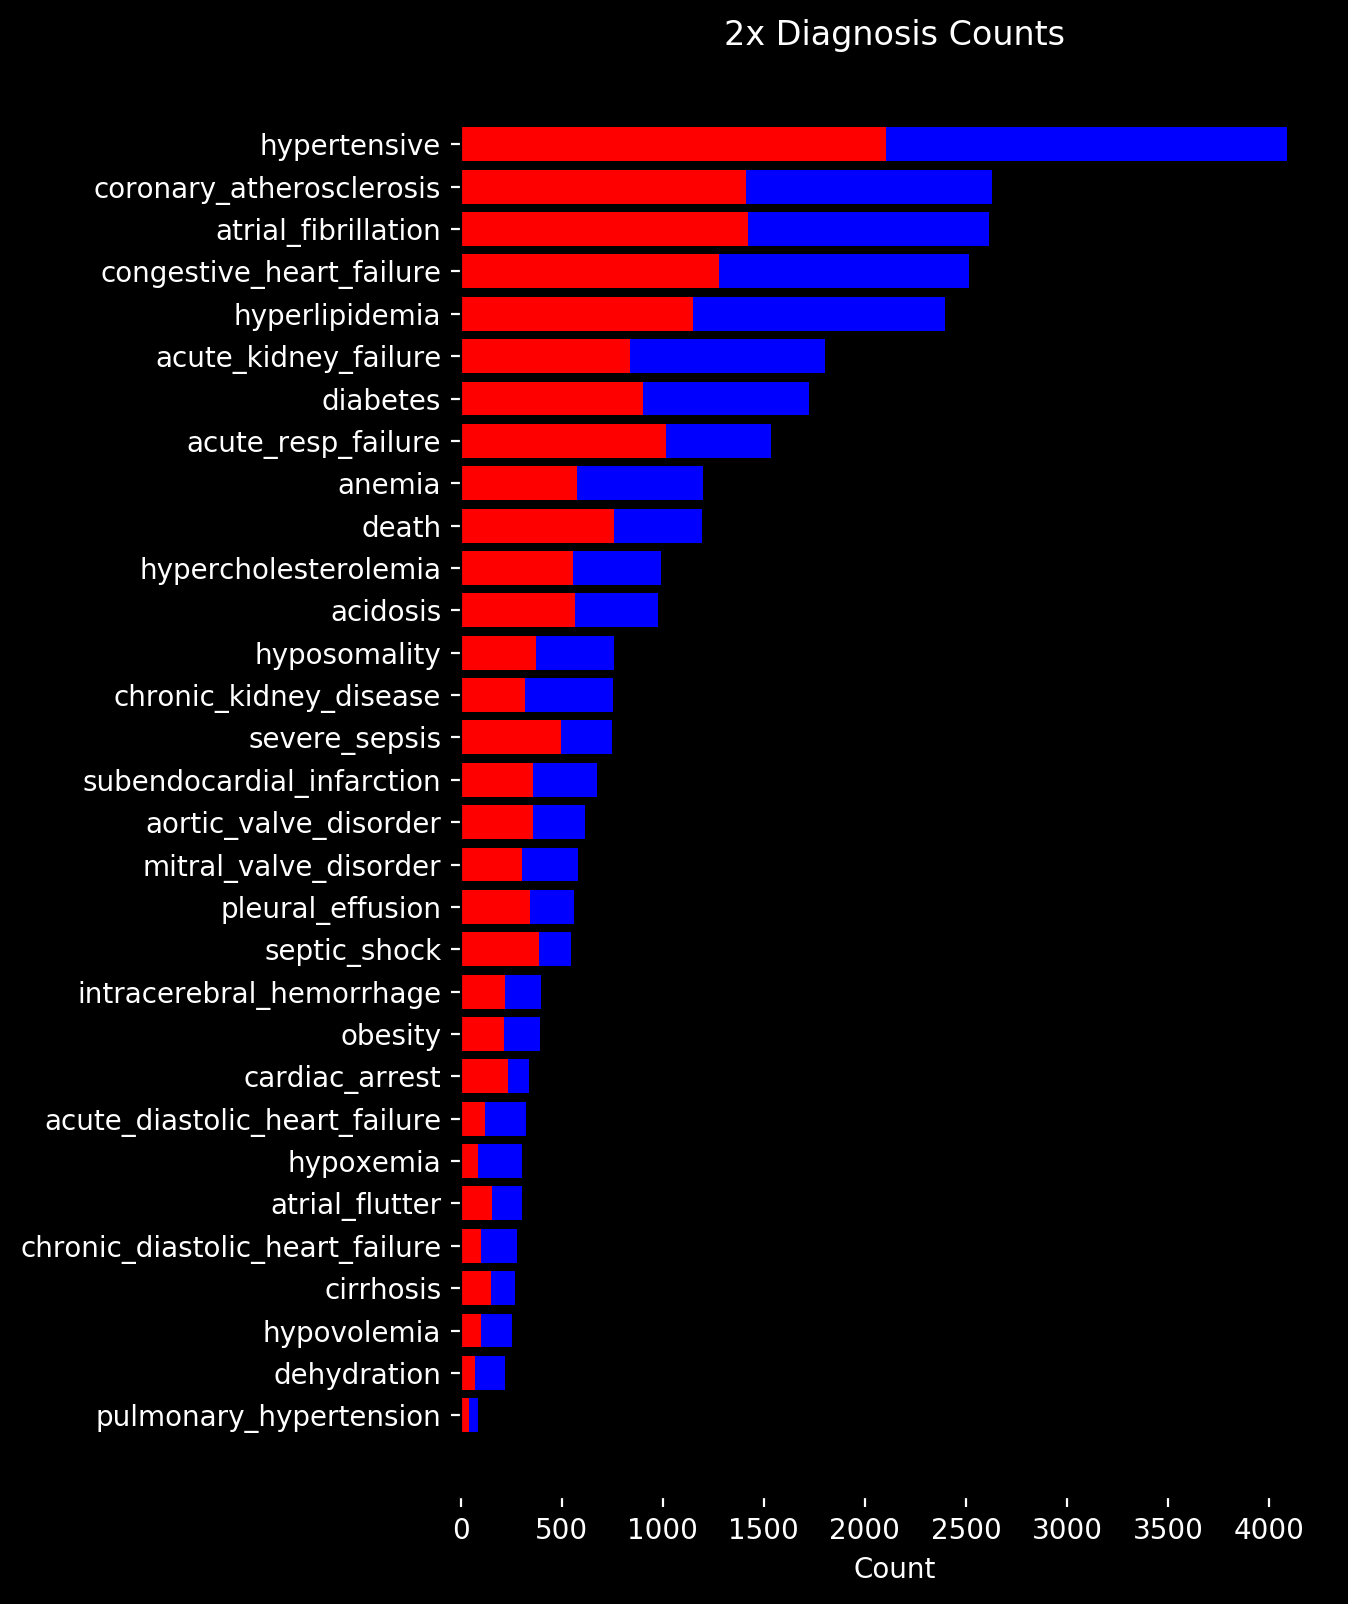

In [90]:
fig = pyplot.figure(1, facecolor='black', figsize=(5, 10))
fig.clear()
axis = fig.gca()
axis.set_facecolor('black')
axis.tick_params(axis='x', colors='white')
axis.tick_params(axis='y', colors='white')
axis.set_xlabel('Count', color='white')
pyplot.barh(range(len(I)), counts[I], color='blue', height=0.8, tick_label=names[::-1])
pyplot.barh(range(len(I)), counts_old[I], color='red', height=0.8, tick_label=names[::-1])
axis.set_title('2x Diagnosis Counts', color='white')
display(fig)

In [39]:
pandas.hstack?

Object `pandas.hstack` not found.


In [26]:
priors[I[::-1]]

code
4019     0.465626
41401    0.300719
42731    0.302998
4280     0.300514
2724     0.276717
5849     0.209651
25000    0.201369
51881    0.174434
2859     0.134753
died     0.132036
2720     0.112389
2762     0.110354
2761     0.085799
5859     0.087646
99592    0.085592
41071    0.074673
4241     0.069275
4240     0.065480
5119     0.063844
78552    0.062356
431      0.044108
27800    0.044666
4275     0.037180
42833    0.037945
79902    0.034464
42732    0.033991
42832    0.032799
5715     0.032131
27652    0.028288
27651    0.024648
4160     0.009669
dtype: float64